# Assignment 2
Hvis objektet fortrenger like mye vann som sin egen vekt, vil det ligge i ro.


$$
\begin{aligned}
\\
\frac{\rho_{pipe}}{\rho_{water}} &= 1\\
\\
m_{inside} \approx 0 \implies  \frac{m_{cf}}{m_{water}} &= 1\\
\\
\frac{\pi(D^2-d^2) L \rho_{cf}}{\pi D^2 L \rho_{water}} &= 1\\
\\
\frac{D^2 - d^2}{D^2} &= \frac{\rho_{water}}{\rho_{cf}}\\
\\
\frac{d}{D} &= \sqrt{1 - \frac{\rho_{water}}{\rho_{cf}}}
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
MAX_DIAMETER = 25 # mm
RHO_W = 1000 # kg/m^3 
EXTERNAL_PRESSURE = 100 # MPa

In [37]:
# Functions

def get_inner_diameter(D, rho_w, rho_material):
    return np.sqrt(1- (rho_w/rho_material)) * D


def plot_max_stress(material, r, sigma_1, sigma_2):
    #Data points for the rectangle in the s1-s2 plane
    s1=(material['XT'],-material['XC'],-material['XC'],material['XT'],material['XT'])
    s2=(material['YT'],material['YT'],-material['YC'],-material['YC'],material['YT'])
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(s1,s2,'--',color='blue',linewidth=1)

    #Origo
    ax.plot((0,),(0,),'+',color='black',markersize=50)

    # Plot points
    ax.plot(sigma_1, sigma_2, color='red')

    # Add text for min and max radial pos
    ax.text(sigma_1[0], sigma_2[0], f'  r_min = {r[0]:.2f}', fontsize=14)
    
    ax.text(sigma_1[-1], sigma_2[-1], f'  r_max = {r[-1]:.2f}', fontsize=14)
    

    ax.set_xlabel(r'$\sigma_1$',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()


def fE_tsaiwu(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    f12, f13, f23 = m['f12'], m['f13'], m['f23']
    F1,  F2,  F3  = (1/XT)-(1/XC) , (1/YT)-(1/YC) , (1/ZT)-(1/ZC)
    F11, F22, F33 =     1/(XT*XC) ,     1/(YT*YC) ,     1/(ZT*ZC)
    F44, F55, F66 =    1/(S23**2) ,    1/(S13**2) ,     1/(S12**2)
    F12 = f12*(F11*F22)**0.5
    F13 = f13*(F11*F33)**0.5
    F23 = f23*(F22*F33)**0.5
    a=F11*(s1**2) + F22*(s2**2) + F33*(s3**2)+ 2*(F12*s1*s2 + F13*s1*s3 + F23*s2*s3)+\
    F44*(s23**2) + F55*(s13**2) + F66*(s12**2)
    if a==0:
        return 0
    b=F1*s1 + F2*s2 +F3*s3
    c=-1
    R=(-b+(b**2-4*a*c)**0.5)/(2*a)
    fE=1/R
    return fE


def fE_tsaiwu_const_s3(s1, s2, s3 ,m): # excludes shear stresses
    XT,YT,ZT,XC,YC,ZC, = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC']
    f12, f13, f23 = m['f12'], m['f13'], m['f23']
    F1,  F2,  F3  = (1/XT)-(1/XC) , (1/YT)-(1/YC) , (1/ZT)-(1/ZC)
    F11, F22, F33 =     1/(XT*XC) ,     1/(YT*YC) ,     1/(ZT*ZC)
    F12 = f12*(F11*F22)**0.5
    F13 = f13*(F11*F33)**0.5
    F23 = f23*(F22*F33)**0.5
    
    a=F11*(s1**2) + F22*(s2**2) + 2*F12*s1*s2

    if a==0:
        return 0
    b=F1*s1 + F2*s2 + 2* (F13*s1*s3 + F23*s2*s3)
    c=-1 + F33*(s3**2) + F3*s3
    R=(-b+(b**2-4*a*c)**0.5)/(2*a)
    fE=1/R
    return fE


def fE_maxstress(s,m):
    # Using local varibles for easier coding and readability..
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    fE=max(s1/XT,-s1/XC,s2/YT,-s2/YC,s3/ZT,-s3/ZC,abs(s12/S12),abs(s13/S13),abs(s23/S23))
    return fE

def fE_maxstrain(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'],m['YT'],m['ZT'],m['XC'],m['YC'],m['ZC'],m['S12'],m['S13'],m['S23']
    E1,E2,E3,v12,v13,v23,G12,G13,G23=m['E1'],m['E2'],m['E3'],m['v12'],m['v13'],m['v23'],m['G12'],m['G13'],m['G23']
    e1=   (1/E1)*s1 + (-v12/E1)*s2 + (-v13/E1)*s3
    e2=(-v12/E1)*s1 +    (1/E2)*s2 + (-v23/E2)*s3
    e3=(-v13/E1)*s1 + (-v23/E2)*s2 +    (1/E3)*s3
    e23,e13,e12 = s23/G23, s13/G13, s12/G12
    f=max( e1/(XT/E1),-e1/(XC/E1),e2/(YT/E2),-e2/(YC/E2),e3/(ZT/E3),-e3/(ZC/E3),
           abs(e12/(S12/G12)),abs(e13/(S13/G13)),abs(e23/(S23/G23)) )
    return f


def fE_hashin(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    if s1>0:
        R = ( 1/( (s1/XT)**2 + (1/S12**2)*(s12**2 + s13**2) ) )**0.5
        fE_FF=1/R
    if s1<=0:
        fE_FF=-s1/XC
    if (s2+s3)>=0:
        temp=( (1/YT**2)*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2) )
        if temp==0:
            fE_IFF = 0
        else:
            R = (1/temp)**0.5
            fE_IFF = 1/R
    if (s2+s3)<0:
        b = (1/YC)*((YC/(2*S23))**2-1)*(s2+s3)
        a = (1/(4*S23**2))*(s2+s3)**2+(1/S23**2)*(s23**2-s2*s3)+(1/S12**2)*(s12**2+s13**2)
        if a==0:
            fE_IFF = 0.0
        else:
            c=-1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF

def fE_hashin_const_s3(s1,s2,s3,m):
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    
    if s1>0:
        R = XT/s1
        fE_FF=1/R

    if s1<=0:
        fE_FF=-s1/XC

    if (s2+s3)<0:
        a = 1/(4*S23**2) * s2**2
        b = 1/(4*S23**2) * 2*s2*s3 - 1 / S23 * s2 * s3 + 1/YC * (YC**2/(4*S23**2) - 1) * s2
        if a==0:
            fE_IFF = 0.0
        else:
            c= 1/(4*S23**2) * s3**2 + 1/YC * (YC**2/(4*S23**2) - 1) * s3 -1
            R=(-b+(b**2-4*a*c)**0.5)/(2*a)
            fE_IFF = 1/R
    return fE_FF, fE_IFF


# ------------ PLOTS ------------

def plot_tsaiwu_various_s3(material, sigma_1, sigma_2, sigma_3, pos):
    
    num_iterations = len(sigma_1)
    
    fig,ax = plt.subplots(figsize=(8,4))

    # Lag en fargegradient basert på antall iterasjoner
    colors = [plt.cm.turbo  (i / (num_iterations - 1)) for i in range(num_iterations)]

    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)

    for i in range(num_iterations): # itterer over alle punkter
        # if (i%2 == 0):
        #     continue

        color = colors[i % len(colors)]
        s3i = sigma_3[i]
        # empty list of normal stresses in the 1-2 plane:
        s1_TW,s2_TW=[],[]  # tsai-wu

        for a in np.linspace(0, 2*np.pi, 3600):
            s1i=np.cos(a)
            s2i=np.sin(a)

            feTW=fE_tsaiwu_const_s3(s1i,s2i,s3i,material)

            # then scaling by the load-proportionality ratio (1/fE):
            s1_TW.append(s1i/feTW)
            s2_TW.append(s2i/feTW)

        # Plot failure envelope
        ax.plot(s1_TW,s2_TW,label=f"S3 = {s3i:.1f}, r = {(MAX_DIAMETER - pos[i]):.2f}",linewidth=1, color=color)
        
        # ---- Plot actual stress ----
        ax.plot(sigma_1[i], sigma_2[i], color=color, marker='o', markersize=4)

    # Add text for positions
    ax.text(sigma_1[0], sigma_2[0], "Outer surface", fontsize=10, color=colors[0])
    ax.text(sigma_1[-1], sigma_2[-1], "Inner surface", fontsize=10, color=colors[-1])

    ax.legend()
    ax.set_xlabel(r'$\sigma_1$ (fiber direction)',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()



def plot_hashin_various_s3(material, sigma_1, sigma_2, sigma_3, pos):
    
    num_iterations = len(pos)
    
    fig,ax = plt.subplots(figsize=(8,4))
    # ax.set_xlim(-3000, 2000)
    # ax.set_ylim(100, -400)

    # Lag en fargegradient basert på antall iterasjoner
    colors = [plt.cm.turbo  (i / (num_iterations - 1)) for i in range(num_iterations)]

    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)

    for i in range(num_iterations): # itterer over alle punkter
      
        color = colors[i % len(colors)]
        s3i = sigma_3[i]
        # empty list of normal stresses in the 1-2 plane:
        s1_Hashin,s2_Hashin=[],[]

        for a in np.linspace(0, 2*np.pi, 3600):
            s1i=np.cos(a)
            s2i=np.sin(a)

            fE_FF, fE_IFF =fE_hashin_const_s3(s1i,s2i,s3i,material)

            # then scaling by the load-proportionality ratio (1/fE):
            s1_Hashin.append(s1i/fE_IFF)
            s2_Hashin.append(s2i/fE_IFF)

        # Plot failure envelope
        ax.plot(s1_Hashin,s2_Hashin,label=f"S3 = {s3i:.1f}, r = {(MAX_DIAMETER - pos[i]):.2f}",linewidth=1, color=color)
        
        # ---- Plot actual stress ----
        ax.plot(sigma_1[i], sigma_2[i], color=color, marker='o')

    # Add text for positions
    ax.text(sigma_1[0], sigma_2[0], "Outer surface", fontsize=10, color=colors[0])
    ax.text(sigma_1[-1], sigma_2[-1], "Inner surface", fontsize=10, color=colors[-1])

    # ax.legend()
    ax.set_xlabel(r'$\sigma_1$ (fiber direction)',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()



def plot_max_strain(material, sigma_1, sigma_2, sigma_3, pos, label_start="", label_end=""):

    num_iterations = len(pos)

    fig,ax = plt.subplots(figsize=(8,4))

    # Lag en fargegradient basert på antall iterasjoner
    colors = [plt.cm.turbo  (i / (num_iterations - 1)) for i in range(num_iterations)]
    
    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)
    
    for i in range(num_iterations): # itterer over alle punkter
      
        color = colors[i % len(colors)]
        s3i = sigma_3[i]

        # empty list of normal stresses in the 1-2 plane:
        s1_ME,s2_ME=[],[]  # maximum strain

        for a in np.linspace(0, 2*np.pi, 3600):
            s1i=np.cos(a)
            s2i=np.sin(a)

            fe_ME=fE_maxstrain((s1i,s2i,s3i,0,0,0), material)

            # then scaling by the load-proportionality ratio (1/fE):
            s1_ME.append(s1i/fe_ME)
            s2_ME.append(s2i/fe_ME)


        ax.plot(s1_ME,s2_ME,color=color,linewidth=1)
        
    # ---- Plot actual stresses ----

    # Plot points
    ax.plot(sigma_1, sigma_2, color='red')

    # Add text for min and max radial pos
    ax.text(sigma_1[0], sigma_2[0], label_start, fontsize=14)
    ax.text(sigma_1[-1], sigma_2[-1], label_end, fontsize=14)


    ax.legend()
    ax.set_xlabel(r'$\sigma_1$',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()

In [4]:
#TODO: fiks enheter
Carbon_EpoxyA = {
    "name": "Carbon/Epoxy(a)", 
    "units": "MPa-mm-Mg", "type": "UD", "fiber": "Carbon",
    "Vf": 0.55, 
    "rho": 1600, # kg/m^3
    "description": "Typical low modulus carbon/Epoxy from TMM4175",  
    "E1": 130000, 
    "E2": 10000, 
    "E3": 10000, 
    "v12": 0.28, "v13": 0.28, "v23": 0.5, 
    "G12": 4500, "G13": 4500, "G23": 3500, 
    "a1": -0.5e-06, "a2": 3.0e-05, "a3": 3.0e-05, 
    "XT": 1800, "YT": 40, "ZT": 40,
    "XC": 1200, "YC": 180, "ZC": 180,
    "S12": 70, "S13": 70, "S23": 40,
    "f12":-0.5, "f13":-0.5, "f23":-0.5
}

In [5]:
D_end = MAX_DIAMETER
num_layers = 2

d = get_inner_diameter(D_end, RHO_W, rho_material=Carbon_EpoxyA['rho'])

ri = d/2.0
ro = D_end/2.0
t = ro - ri
h = t / num_layers

print(f"Inner radius: {ri:.5f} mm\nOuter radius: {ro:.5f} mm\nThickness: {t:.5f} mm\nLaminate thickness: {h:.5f} mm")


Inner radius: 7.65466 mm
Outer radius: 12.50000 mm
Thickness: 4.84534 mm
Laminate thickness: 2.42267 mm


In [6]:
# Force calculation for Abaqus

A = 0.5 * np.pi * ro**2
F = A * EXTERNAL_PRESSURE
F

24543.692606170258

# Results From Abaqus

In [7]:
# Position (from r0 to ri)
pos = [
    0,
    0.482111,
    0.96419,
    1.44623,
    1.92824,
    2.41019,
    2.41019,
    2.89234,
    3.3751,
    3.85853,
    4.34273,
    4.82781,
]

S11 = [
    -244.178,
    -244.178,
    -244.178,
    -244.178,
    -244.178,
    -244.178,
    -440.439,
    -432.477,
    -420.548,
    -417.767,
    -427.01,
    -435.068,
]

S22 = [
    -89.8445,
    -89.6269,
    -89.1631,
    -88.6367,
    -88.0361,
    -87.7157,
    -71.3565,
    -66.8048,
    -57.4717,
    -47.5171,
    -36.539,
    -30.734,
]

S33 = [
    -100.201,
    -100.418,
    -100.882,
    -101.408,
    -102.009,
    -102.33,
    -94.3609,
    -85.6005,
    -67.4482,
    -47.6588,
    -25.3043,
    -13.3474,
]

# Max stress and strain

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


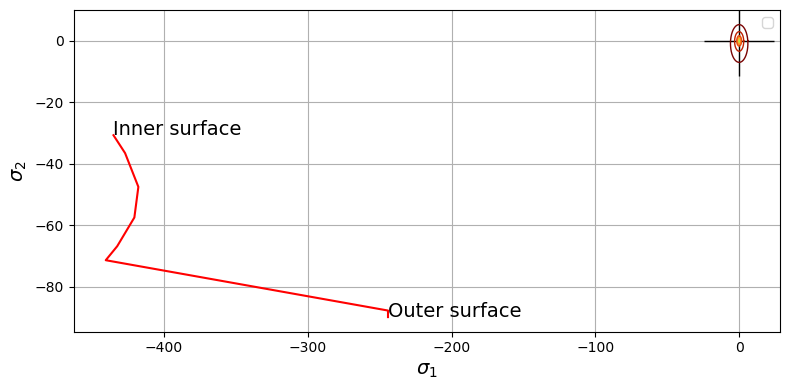

In [38]:
plot_max_strain(Carbon_EpoxyA, sigma_1=S11, sigma_2=S22, sigma_3=S33, pos=pos, label_start="Outer surface", label_end="Inner surface")

# Tsai Wu

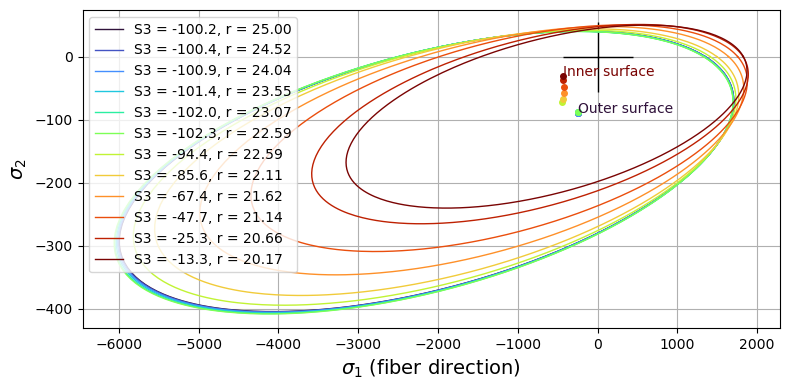

In [29]:
# Get D and d
D = MAX_DIAMETER
d = get_inner_diameter(D, RHO_W, rho_material=Carbon_EpoxyA['rho'])

plot_tsaiwu_various_s3(Carbon_EpoxyA, sigma_1=S11, sigma_2=S22, sigma_3=S33, pos=pos)

# Hashin

C:\Users\hakon\AppData\Local\Temp\ipykernel_16316\4034199888.py:220: RuntimeWarning: divide by zero encountered in scalar divide
  s1_Hashin.append(s1i/fE_IFF)
C:\Users\hakon\AppData\Local\Temp\ipykernel_16316\4034199888.py:221: RuntimeWarning: invalid value encountered in scalar divide
  s2_Hashin.append(s2i/fE_IFF)


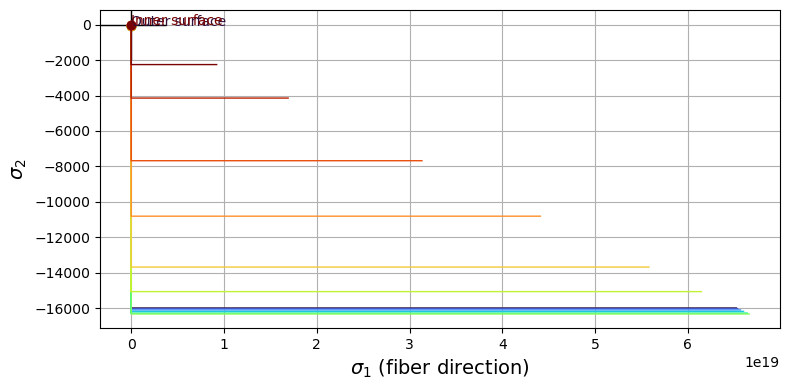

In [39]:
plot_hashin_various_s3(Carbon_EpoxyA, sigma_1=S11, sigma_2=S22, sigma_3=S33, pos=pos)